This is a customized code of wagenaars code given in the link:
https://github.com/wagenaartje/pinn4hcf

In [ ]:
import torch
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

torch.manual_seed(5)
np.random.seed(5)

# Physical constants
gamma = 1.4
r_inf = 1.0
p_inf = 1.0
M_inf = 2.0
v_inf = 0.0
u_inf = math.sqrt(gamma*p_inf/r_inf)*M_inf

# Geometry
x_min = 0.0
x_max = 2
y_min = 0.0
y_max = 2.0
w_angle = math.radians(10)
w_start = 1

# Hyperparameters
num_ib = 500


def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs).to(device), retain_graph=True, create_graph=True)


''' Model definition '''
# Generator
class Generator (torch.nn.Module):
         
  def __init__(self):
    super(Generator, self).__init__()
    activation = torch.nn.Tanh()
    # activation = torch.nn.SiLU()
    # activation = SinActivation()
    t1 = 15
    # torch.manual_seed(0)
    self.net = torch.nn.Sequential(
            torch.nn.Linear(2, t1), torch.nn.Tanh(),
            torch.nn.Linear(t1, t1), torch.nn.Tanh(),
            torch.nn.Linear(t1, t1), torch.nn.Tanh(),
            torch.nn.Linear(t1, t1), torch.nn.Tanh(),
            torch.nn.Linear(t1, 5)
        )
    # self.net.append( activation )
    # self.net.append( torch.nn.Linear(t1, 5) )


  def forward(self, x, y):
        # Pass inputs through the network
        output = self.net(torch.hstack((x, y)))
        
        # Apply exponential function only to the first output
        output[:, 0] = torch.exp(output[:, 0])
        output[:, 1] = torch.exp(output[:, 1])
        return output

def pde( x, y ):
        state = generator(x,y )
        r = state[:, 0]
        p = state[:, 1]
        u = state[:,2]
        v = state[:, 3]
        viscosity = state[:, 4]**2

       
        rE = p/(gamma - 1) +0.5*r*(u**2+v**2)

        u1 = r
        u2 = r*u
        u3 = r*v
        u4 = rE

        f1 = r*u
        f2 = r*u*u+p
        f3 = r*u*v
        f4 = (rE+p)*u
    
        g1 = r*v
        g2 = r*v*u
        g3 = r*v*v + p
        g4 = (rE+p)*v
        

        f1_x = torch.autograd.grad(f1, x, grad_outputs=torch.ones_like(f1),create_graph=True)[0]
        f2_x = torch.autograd.grad(f2, x, grad_outputs=torch.ones_like(f2),create_graph=True)[0]
        f3_x = torch.autograd.grad(f3, x, grad_outputs=torch.ones_like(f3),create_graph=True)[0]
        f4_x = torch.autograd.grad(f4, x, grad_outputs=torch.ones_like(f4),create_graph=True)[0]

        g1_y = torch.autograd.grad(g1, y, grad_outputs=torch.ones_like(g1),create_graph=True)[0]
        g2_y = torch.autograd.grad(g2, y, grad_outputs=torch.ones_like(g2),create_graph=True)[0]
        g3_y = torch.autograd.grad(g3, y, grad_outputs=torch.ones_like(g3),create_graph=True)[0]
        g4_y = torch.autograd.grad(g4, y, grad_outputs=torch.ones_like(g4),create_graph=True)[0]

        u1_x = torch.autograd.grad(u1, x, grad_outputs=torch.ones_like(u1),create_graph=True)[0]
        u2_x = torch.autograd.grad(u2, x, grad_outputs=torch.ones_like(u2),create_graph=True)[0]
        u3_x = torch.autograd.grad(u3, x, grad_outputs=torch.ones_like(u3),create_graph=True)[0]
        u4_x = torch.autograd.grad(u4, x, grad_outputs=torch.ones_like(u4),create_graph=True)[0]

        u1_xx = torch.autograd.grad(u1_x, x, grad_outputs=torch.ones_like(u1_x),create_graph=True)[0]
        u2_xx = torch.autograd.grad(u2_x, x, grad_outputs=torch.ones_like(u2_x),create_graph=True)[0]
        u3_xx = torch.autograd.grad(u3_x, x, grad_outputs=torch.ones_like(u3_x),create_graph=True)[0]
        u4_xx = torch.autograd.grad(u4_x, x, grad_outputs=torch.ones_like(u4_x),create_graph=True)[0]

        u1_y = torch.autograd.grad(u1, y, grad_outputs=torch.ones_like(u1),create_graph=True)[0]
        u2_y = torch.autograd.grad(u2, y, grad_outputs=torch.ones_like(u2),create_graph=True)[0]
        u3_y = torch.autograd.grad(u3, y, grad_outputs=torch.ones_like(u3),create_graph=True)[0]
        u4_y = torch.autograd.grad(u4, y, grad_outputs=torch.ones_like(u4),create_graph=True)[0]

        u1_yy = torch.autograd.grad(u1_y, y, grad_outputs=torch.ones_like(u1_y),create_graph=True)[0]
        u2_yy = torch.autograd.grad(u2_y, y, grad_outputs=torch.ones_like(u2_y),create_graph=True)[0]
        u3_yy = torch.autograd.grad(u3_y, y, grad_outputs=torch.ones_like(u3_y),create_graph=True)[0]
        u4_yy = torch.autograd.grad(u4_y, y, grad_outputs=torch.ones_like(u4_y),create_graph=True)[0]
        # print(f1_x)
        r1 = f1_x + g1_y - viscosity * (u1_xx + u1_yy)
        r2 = f2_x + g2_y - viscosity * (u2_xx + u2_yy)
        r3 = f3_x + g3_y - viscosity * (u3_xx + u3_yy)
        r4 = f4_x + g4_y - viscosity * (u4_xx + u4_yy)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(f1),create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(f1),create_graph=True)[0]

        d=0.12*(abs(u_x)-u_x)  + 1+0.12*(abs(v_y)-v_y)
        l_pde=((r1/d)**2).mean()+((r2/d)**2).mean()+((r3/d)**2).mean()+((r4/d)**2).mean()
        f_v = (state[:,[4]]**2).mean()
        return l_pde, f_v
  
def loss_slip (x,y, thetas):
    # for x in coords: x.requires_grad = True
        state = generator(x,y )
        r = state[:, 0]
        p = state[:, 1]
        u = state[:,2]
        v = state[:, 3]
        viscosity = state[:, 4]**2
    
        cos = torch.cos(thetas)
        sin = torch.sin(thetas)

        u_angle = u * cos + v * sin

        fb = (u_angle**2).mean()
    
        return fb

def loss_inlet (x,y, u_bc):
        u_pred = generator(x,y )
    
        loss = ((u_pred[:,0] - u_bc[0])**2).mean() + \
           ((u_pred[:,1] - u_bc[1])**2).mean() + \
           ((u_pred[:,2] - u_bc[2])**2).mean() + \
           ((u_pred[:,3] - u_bc[3])**2).mean()
    
        return loss


def evaluate ():
    global mse_bc, mse_pde, mse_v
    optimizer.zero_grad()                     

    loss_r, loss_v = pde(x_r,y_r)        
    loss_b = loss_slip(x_b,y_b, t_b)
    loss_l = loss_inlet(x_l,y_l, u_l)
    loss_c = loss_slip(x_w,y_w, t_w) 

    loss_bc = loss_c + loss_l + loss_b

    mse_bc = loss_bc.item()
    mse_pde=loss_r.item()
    mse_v=loss_v.item()
    loss = loss_r + 1 * loss_bc + 1e-2 * loss_v
    loss.backward()

    return loss

if __name__ == '__main__':
    # Set up hardware 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.set_default_dtype(torch.float32)



    x_l = torch.full((num_ib, 1), x_min, device=device)
    y_l = torch.linspace(y_min, y_max, num_ib, device=device).reshape(-1,1)

    u_l = (r_inf, p_inf, u_inf, v_inf)

    # Top boundary
    x_t = torch.linspace(x_min, x_max, num_ib, device=device).reshape(-1,1)
    y_t = torch.full((num_ib, 1), y_max, device=device)

    t_t = torch.full((num_ib,1), -torch.pi/2,device=device)

    # Bottom boundary
    x_b = torch.linspace(x_min,w_start, num_ib+1, device=device)[:-1].reshape(-1,1)
    y_b = torch.full((num_ib, 1), y_min, device=device)

    t_b = torch.full((num_ib,1), torch.pi/2, device=device)

    # Wedge boundary
    x_w = torch.linspace(w_start, x_max, num_ib, device=device).reshape(-1,1)
    geom = lambda x:  (x-w_start)*math.tan(w_angle)
    y_w = y_min +geom(x_w)

    t_w = torch.full((num_ib,1), torch.pi/2 + w_angle, device=device)



    # Convert to tuples
    # x_l = (x_l, y_l)
    # x_t = (x_t, y_t)
    # x_b = (x_b, y_b)
    # x_w = (x_w, y_w)
    # x_l = torch.hstack([x_l, y_l])
    # x_t = torch.hstack([x_t, y_t])
    # x_b = torch.hstack([x_b, y_b])
    # x_w = torch.hstack([x_w, y_w])
    # x_r = (x_r[:,[0]], x_r[:,[1]])
    # x_test, u_test = reference(device)
     # print("Shape of tuple:", (rows, columns))
    # n1=101
    # [xp,yp] = np.meshgrid(np.linspace(x_min,x_max,n1),np.linspace(y_min,y_max,n1))
    # xf=xp.flatten()
    # yf=yp.flatten()
    # xin= np.vstack([xf,yf])
    # xin=np.transpose(xin)
    # t1=y_min  +geom(xin[:,0])
    # t1[np.isnan(t1)] = 0
    # mapping = xin[:,1] > t1
    # mapping1=xin[:,0]<w_start+0*xin[:,0]
    # mapping=mapping+mapping1
    # xin1 = xin[mapping,:]
    # x_test1 = torch.tensor(xin1[:,0], device=device, dtype=torch.float32)
    # y_test1 = torch.tensor(xin1[:,1], device=device, dtype=torch.float32)
    # x_test1=torch.reshape(x_test1,(-1,1))
    # y_test1=torch.reshape(y_test1,(-1,1))
    # x_r=x_test1
    # y_r=y_test1

    with open('fluent_mesh.dat', 'r') as file:
        lines = file.readlines()

# Skip the first line and split each line into a list of elements
    data = [line.strip().split() for line in lines[1:]]

# Convert the list of lists to a NumPy array
    data_in = np.array(data, dtype=float)  # Use dtype=float if your data is numeric

    x_in=data_in[:,1]
    y_in=data_in[:,2]
    x_test1 = torch.tensor(x_in, device=device, dtype=torch.float32)
    y_test1 = torch.tensor(y_in, device=device, dtype=torch.float32)
    x_r=torch.reshape(x_test1,(-1,1))
    y_r=torch.reshape(y_test1,(-1,1))
    # x_test = (x_test1, y_test1)
    # x_r=x_test
    # print(x_test1.shape)

    # x_test = (x_test1, y_test1)
    # x_test=torch.hstack([x_test1, y_test1])
    # x_r=x_test
    x_r=x_r.requires_grad_()
    x_l =x_l.requires_grad_()
    x_t = x_t.requires_grad_()
    x_b =x_b.requires_grad_()
    x_w =x_w.requires_grad_()


    y_r=y_r.requires_grad_()
    y_l =y_l.requires_grad_()
    y_t = y_t.requires_grad_()
    y_b =y_b.requires_grad_()
    y_w =y_w.requires_grad_()

    # Set up models and optimizer
    generator = Generator().to(device)
    optimizer = torch.optim.LBFGS(generator.parameters(),lr=0.1,max_iter=20)

    # Start looping
    epoch = 0
    start_time = time.time()
    lowest_loss = None
    lowest_loss_epoch = 0

    for i in range(101):
        epoch_start_time = time.time() 

        # Optimize loss function
        if epoch > 0:
            loss = optimizer.step(evaluate)
        else:
            loss = evaluate()

        # Calculate L2 error
        

        # Print status
        print(f'Epoch: {epoch:4d} - Time: {time.time() - epoch_start_time:.2f} - MSE_r: {mse_pde:.2e} - MSE_v: {mse_v:.2e} - MSE_bc: {mse_bc:.2e} ')
        epoch += 1
        if mse_pde+mse_bc<1e-3:
                break

    # u_pred = generator(x_test)    


Epoch:    0 - Time: 2.63 - MSE_r: 2.23e-01 - MSE_v: 3.01e-03 - MSE_bc: 4.75e+00 
Epoch:    1 - Time: 23.02 - MSE_r: 8.81e-03 - MSE_v: 2.14e-03 - MSE_bc: 7.61e-02 
Epoch:    2 - Time: 23.33 - MSE_r: 1.25e-02 - MSE_v: 4.16e-03 - MSE_bc: 3.32e-02 
Epoch:    3 - Time: 25.59 - MSE_r: 6.49e-03 - MSE_v: 1.38e-02 - MSE_bc: 2.58e-02 
Epoch:    4 - Time: 23.58 - MSE_r: 3.60e-03 - MSE_v: 6.59e-02 - MSE_bc: 1.97e-02 
Epoch:    5 - Time: 24.30 - MSE_r: 2.29e-03 - MSE_v: 1.08e-01 - MSE_bc: 1.60e-02 
Epoch:    6 - Time: 25.35 - MSE_r: 1.23e-03 - MSE_v: 1.21e-01 - MSE_bc: 1.54e-02 
Epoch:    7 - Time: 23.99 - MSE_r: 1.46e-03 - MSE_v: 1.15e-01 - MSE_bc: 1.29e-02 
Epoch:    8 - Time: 23.90 - MSE_r: 1.73e-03 - MSE_v: 1.04e-01 - MSE_bc: 1.15e-02 
Epoch:    9 - Time: 23.93 - MSE_r: 1.59e-03 - MSE_v: 9.41e-02 - MSE_bc: 1.09e-02 
Epoch:   10 - Time: 23.94 - MSE_r: 1.44e-03 - MSE_v: 8.79e-02 - MSE_bc: 1.05e-02 
Epoch:   11 - Time: 23.76 - MSE_r: 1.46e-03 - MSE_v: 7.15e-02 - MSE_bc: 9.53e-03 
Epoch:   12 - Tim

In [2]:
u_pred=generator(x_r,y_r).cpu().detach().numpy()
r=u_pred[:,0]
p=u_pred[:,1]
u=u_pred[:,2]
v=u_pred[:,3]
# x_test=torch.stack(x_test)
# x_test=torch.reshape(x_test,(2,-1))
x_test1=x_r.detach().cpu().numpy()
y_test1=y_r.detach().cpu().numpy()
# r=r.detach().cpu().numpy()
# p=p.detach().cpu().numpy()
# u=u.detach().cpu().numpy()
# v=v.detach().cpu().numpy()

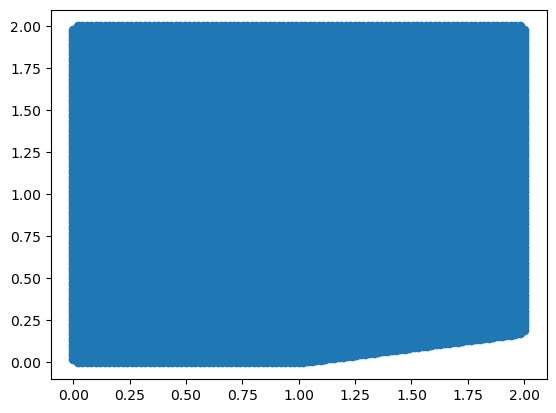

In [3]:
plt.scatter(x_test1,y_test1)

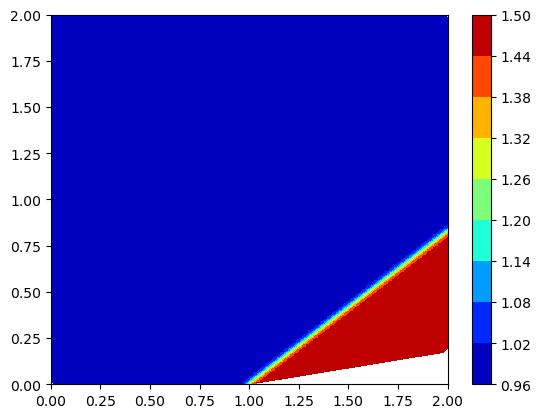

In [4]:
triang = Triangulation(x_test1.flatten(), y_test1.flatten())
plt.tricontourf(triang, r, cmap='jet')
plt.colorbar()